### Questions to answer
1) In 2017 was the country an important factor for the possibility to work from home?
2) Is Employment Status an indicator for a remote job?
3) Which formal education allows most workers to have a remote job?
4) Do smaller companies offer working remotely more often?
5) What are the determining factors in predicting if working from home is possible?

First, let's read in the data and the necessary libraries.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline

## Gather data

I decided to work with the Stackoverflow survey 2017 as it contains the information about working from home that I am most curious about

In [2]:
print(os.getcwd())  # get current working directory


c:\Users\Ramona\Documents\Vs_code projects\Udacity_project\udacity-data-science-project-1\notebooks


In [3]:
# Load in data
df = pd.read_csv("../data/survey_results_public.csv")


## Assess data

In [4]:
# Take a look at the data
df.head()


,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51392 entries, 0 to 51391
Columns: 154 entries, Respondent to ExpectedSalary
dtypes: float64(6), int64(1), object(147)
memory usage: 60.4+ MB


In [6]:
# check the number of rows and columns
num_rows_n = df.shape[0]  # Provide the number of rows in the dataset
num_cols_n = df.shape[1]  # Provide the number of columns in the dataset
print(f"Number of rows: {num_rows_n} \nNumber of columns: {num_cols_n}")


Number of rows: 51392 
Number of columns: 154


In [7]:
# Taking a look at numeric data
df.describe()


,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary
count,51392.000000,42695.000000,40376.000000,20600.000000,36592.000000,12891.000000,2566.000000
mean,25696.500000,7.300574,6.957078,3.952282,8.429875,56298.480641,33142.220468
std,14835.736854,1.955444,2.167652,7.564722,1.390635,39880.905277,30162.988829
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12848.750000,6.000000,6.000000,1.000000,8.000000,26440.371839,4490.492484
50%,25696.500000,8.000000,7.000000,1.000000,9.000000,50000.000000,29364.263691
75%,38544.250000,9.000000,8.000000,4.000000,10.000000,80000.000000,50403.225806
max,51392.000000,10.000000,10.000000,40.000000,10.000000,197000.000000,187500.000000


In [8]:
# Load in schema
schema = pd.read_csv("../data/survey_results_schema.csv")
schema.head()


,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to ope...
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree..."


Assessment of the Survey Results Dataset and schema: 
- To answer the above questions, I need to have a deeper understanding of the variables HomeRemote, Country, Profession, Company Size
- To get conclusive answer, I will exclude all survey participants without jobs
- I will take most of the above numeric datapoints in for prediction of Working Remote possibilies
- I need to take care of missing values, especially in the Home Remote column
- I need to filter for the top 10 countries to get interpretable answers

#### Look at necessary data to answer the above questions

In [9]:
def get_description(column_name: str, schema: pd.DataFrame = schema):
    """
    INPUT - schema - pandas dataframe with the schema of the developers survey
            column_name - string - the name of the column you would like to know about
    OUTPUT -
            desc - string - the description of the column
    """
    desc = list(schema[schema["Column"] == column_name]["Question"])[0]
    return desc


In [10]:
# get description of the columns of interest
col_list = ["HomeRemote", "JobSatisfaction", "Salary", "HoursPerWeek", "Country","EmploymentStatus"]
for i in col_list:
    print(get_description(i))


How often do you work from home or remotely?
Job satisfaction rating
What is your current annual base salary, before taxes, and excluding bonuses, grants, or other compensation?
During a typical week, approximately how many hours do you spend on activities related to finding new job opportunities?Please adjust the slider to the appropriate number of hours. The box to the right will indicate the number of hours you have chosen.
In which country do you currently live?
Which of the following best describes your current employment status?


In [11]:
# look at data types
df[["HomeRemote", "JobSatisfaction", "Salary", "HoursPerWeek", "Country","EmploymentStatus"]].dtypes


HomeRemote           object
JobSatisfaction     float64
Salary              float64
HoursPerWeek        float64
Country              object
EmploymentStatus     object
dtype: object

Dependent on the datatype the data cleaning process will look different

In [12]:
# It is necessary to exclude based on employment status 
df["EmploymentStatus"].value_counts()

Employed full-time                                      36148
Independent contractor, freelancer, or self-employed     5233
Employed part-time                                       3180
Not employed, and not looking for work                   2791
Not employed, but looking for work                       2786
I prefer not to say                                      1086
Retired                                                   168
Name: EmploymentStatus, dtype: int64

A few days each month                                      15454
Never                                                      13975
All or almost all the time (I'm full-time remote)           4905
Less than half the time, but at least one day each week     4147
More than half, but not all, the time                       1909
It's complicated                                            1849
About half the time                                         1769
Name: HomeRemote, dtype: int64


Text(0.5, 1.0, 'How often do you work from home or remotely?')

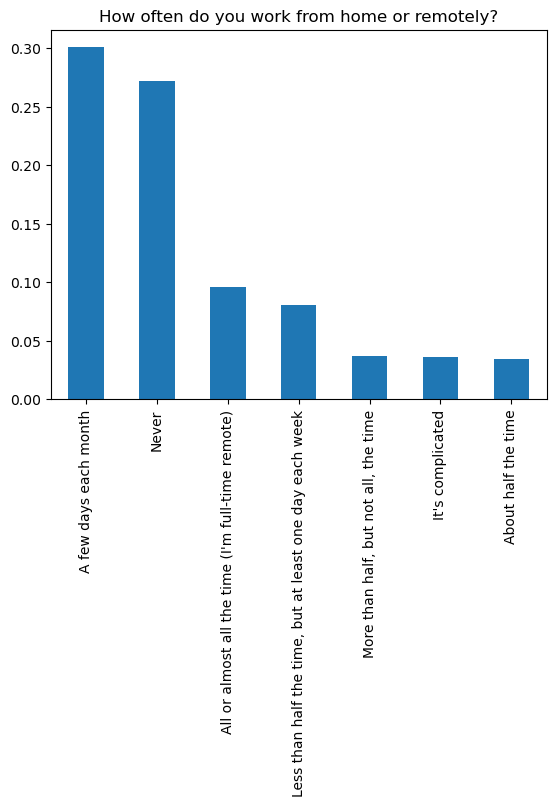

In [13]:
# some graphs for Home Remote
status_vals = df.HomeRemote.value_counts()
print(status_vals)
(status_vals / df.shape[0]).plot(kind="bar")
plt.title("How often do you work from home or remotely?")


## Data Cleaning and Preparation

In [14]:
# To prepare data cleaning we first need to know how many answers we have to the Home Remote question
prop_home_remote = 1 - df.isnull()["HomeRemote"].mean()
prop_home_remote


0.8563200498132005

~86% of participants, answered the question. As this will be my outcome variable I want to predict on later, I decide to delete rows with no answers on the HomeRemote question

In [15]:
# drop all columns of participants without entries to the HomeRemote question
hr = df.dropna(subset=["HomeRemote"], axis=0)
# check
1 - hr.isnull()["HomeRemote"].mean()

1.0

In [16]:
# It also makes sense only to include participants who are full-time or part-time or independent contractor, freelancer, or self-employed
hr = hr[hr["EmploymentStatus"].isin(["Employed part-time", "Employed full-time","Independent contractor, freelancer, or self-employed"])]


#### The above values do not really help to answer my first question, that is why I decided to categorize the answers

In [17]:
# In order to predict working from home later, I decide to create a new categorical variable
def remote_possible(home_cat):
    """
    INPUT
        home_cat - HomeRemote categorical input

    OUTPUT
        return 1 if the category falls into 'it is possible to work from home without problems'
        return 0 otherwise

    """
    if home_cat in (
        "A few days each month",
        "All or almost all the time (I'm full-time remote)",
        "More than half, but not all, the time",
        "About half the time",
        "Less than half the time, but at least one day each week",
    ):
        return 1
    else:
        return 0


hr["HomeRemote"].apply(remote_possible)[
    :5
]  # Test of the function if it only provided 1 and 0


1    1
2    1
3    1
4    0
6    1
Name: HomeRemote, dtype: int64

In [18]:
# create a variable out of the function above 
hr['RemotePossible']=hr["HomeRemote"].apply(remote_possible)

In [19]:
# Show percentage of workers with possibility to work from home
remote_perc = hr["RemotePossible"].mean()
remote_perc

0.640421856532412

64% of the respondents are able to work from home.

For the first question I am  interested in country data 

Text(0.5, 1.0, 'Country')

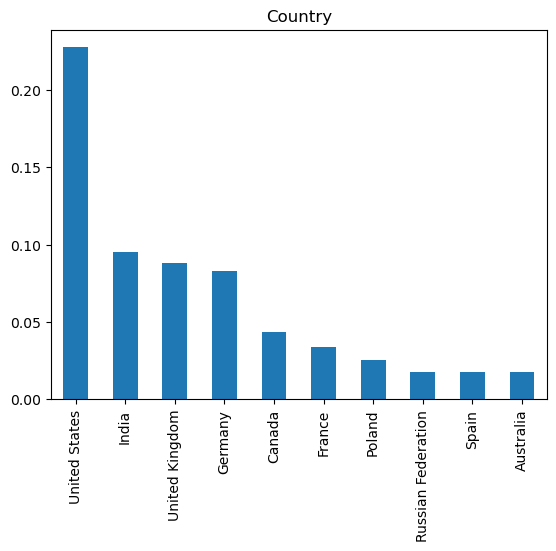

In [20]:
# First, I will look at the top 10 countries of participants
count_vals = hr.Country.value_counts()
(count_vals[:10] / hr.shape[0]).plot(kind="bar")
plt.title("Country")


In [21]:
rp_country = hr.groupby(["Country"]).mean()["RemotePossible"].sort_values().dropna()
rp_country


Country
Cayman Islands      0.0
Saint Lucia         0.0
Reunion (French)    0.0
Bermuda             0.0
Falkland Islands    0.0
                   ... 
Swaziland           1.0
Eritrea             1.0
Macau               1.0
Cape Verde          1.0
Sudan               1.0
Name: RemotePossible, Length: 188, dtype: float64

The above values do not give any insights, I have to restrict the countries to the top 10 to get the insightes I am searching for.
I will group the countries and only investigate the top 10 countries of survey respondents. 

In [22]:
hr["country_groups"] = np.where(
    hr["Country"].isin(
        [
            "United States",
            "India",
            "United Kingdom",
            "Germany",
            "France",
            "Canada",
            "Poland",
            "Australia",
            "Russian Federation",
            "Spain",
        ]
    ),
    hr["Country"],
    "Other",
)


In [23]:
# To answer the first question, I will have a look at different countries
hr.groupby(["country_groups"]).mean()["RemotePossible"].sort_values().dropna()


country_groups
France                0.474565
Spain                 0.505089
Germany               0.568767
United Kingdom        0.583656
India                 0.640867
Australia             0.643871
Canada                0.647335
Other                 0.647518
Poland                0.677305
United States         0.699621
Russian Federation    0.735369
Name: RemotePossible, dtype: float64

## Analyze and Visualize

### Question 1: In 2017 was the country an important factor for the possibility to work from home?

[Text(0, 0, 'Russian Federation'),
 Text(1, 0, 'United States'),
 Text(2, 0, 'Poland'),
 Text(3, 0, 'Other'),
 Text(4, 0, 'Canada'),
 Text(5, 0, 'Australia'),
 Text(6, 0, 'India'),
 Text(7, 0, 'United Kingdom'),
 Text(8, 0, 'Germany'),
 Text(9, 0, 'Spain'),
 Text(10, 0, 'France')]

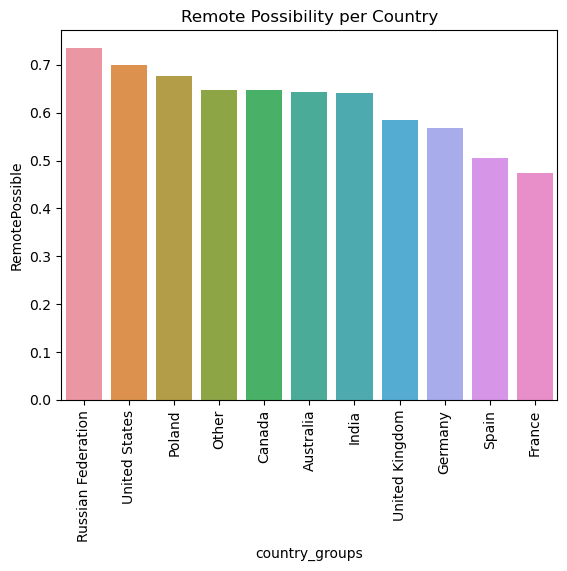

In [24]:
# Plot it for better visualization
country_remote_plot = (
    hr.groupby(["country_groups"])
    .mean()["RemotePossible"]
    .sort_values(ascending=False)
    .reset_index()
)

ax = sns.barplot(x="country_groups", y="RemotePossible", data=country_remote_plot)
plt.title("Remote Possibility per Country")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)



Interestingly in Russia ~74%  of workers have the possibility to work from home, second rank is United States (~70%), 
Lowest rates for remote workers are in France (~47%) and Spain ~51%. Most likely this changed after 2017 with the Corona pandemic. 

### Question 2: Is Employment Status an indicator for a remote job? 

[Text(0, 0, 'Independent contractor, freelancer, or self-employed'),
 Text(1, 0, 'Employed part-time'),
 Text(2, 0, 'Employed full-time')]

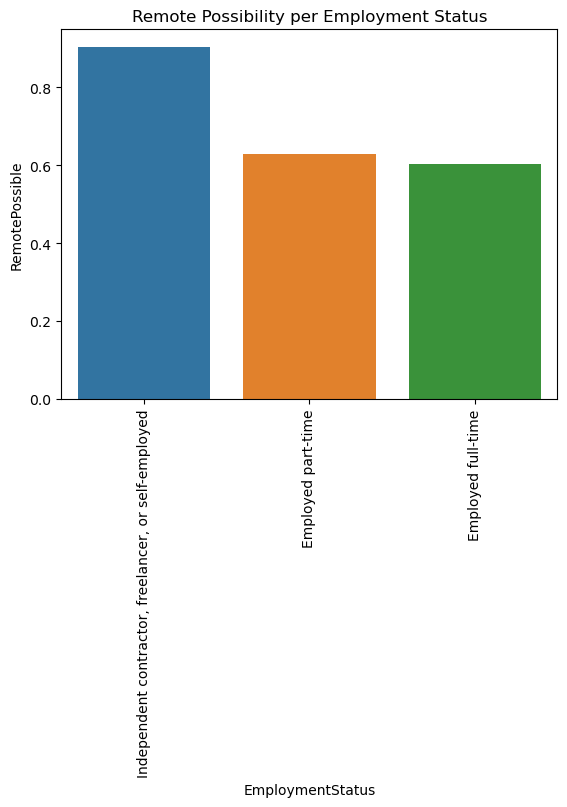

In [25]:
# Plot it for better visualization
country_remote_plot = (
    hr.groupby(["EmploymentStatus"])
    .mean()["RemotePossible"]
    .sort_values(ascending=False)
    .reset_index()
)

ax = sns.barplot(x="EmploymentStatus", y="RemotePossible", data=country_remote_plot)
plt.title("Remote Possibility per Employment Status")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Independent contractor, freelancer, or self-employed have by far the highest probability to work from home. Part time or full time does not seem to be an important factor. 

I am also curious to see if the employment status is an important factor per country.

[Text(0, 0, 'Russian Federation'),
 Text(1, 0, 'Spain'),
 Text(2, 0, 'Germany'),
 Text(3, 0, 'India'),
 Text(4, 0, 'Other'),
 Text(5, 0, 'Canada'),
 Text(6, 0, 'United States'),
 Text(7, 0, 'Australia'),
 Text(8, 0, 'France'),
 Text(9, 0, 'Poland'),
 Text(10, 0, 'United Kingdom')]

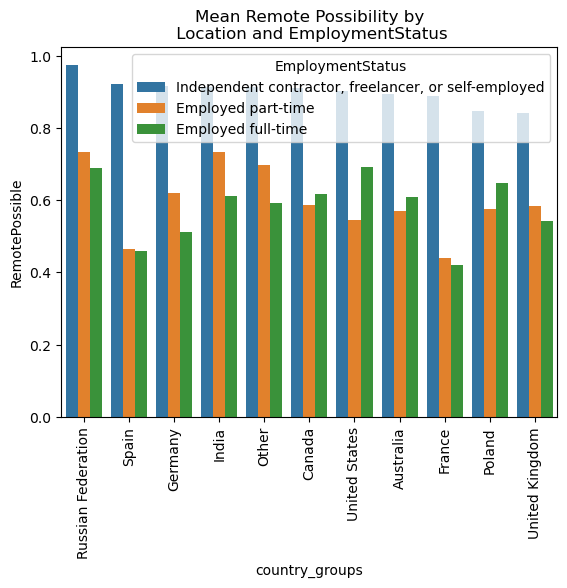

In [26]:
remote_employement = hr.copy()

remote_employement = remote_employement[
    remote_employement["EmploymentStatus"].isin(
        [
            "Employed part-time",
            "Employed full-time",
            "Independent contractor, freelancer, or self-employed",
        ]
    )
]


remote_employement_plot = (
    remote_employement.groupby(["country_groups", "EmploymentStatus"])["RemotePossible"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

ex = sns.barplot(
    x="country_groups",
    y="RemotePossible",
    hue="EmploymentStatus",
    data=remote_employement_plot,
)
plt.title("Mean Remote Possibility by\n Location and EmploymentStatus")
ex.set_xticklabels(ex.get_xticklabels(), rotation=90)


Interestingly, in all countries independent contractors, freelancers, or self-employed have the highest work from home rate. Especially in the country with lowest remote rates (e.g. Spain and France) the Employment Status is an important factor for remote workers. 

### Question 3: Which formal education allows most workers to have a remote job?

In [27]:
hr.groupby(["FormalEducation"]).mean()["RemotePossible"].sort_values().dropna()


FormalEducation
Secondary school                                                     0.611065
Professional degree                                                  0.622291
Master's degree                                                      0.629324
Bachelor's degree                                                    0.635385
I prefer not to answer                                               0.641949
Some college/university study without earning a bachelor's degree    0.668547
Primary/elementary school                                            0.710983
Doctoral degree                                                      0.713580
I never completed any formal education                               0.726073
Name: RemotePossible, dtype: float64

No, the respondents of 'I never completed any formal education have the highest remote working scores. Primary/elementary school also ranks in the top 3. It is save to say that there is no positive relationship with working from home and formal education level. 

### Question 4: Are bigger companies allowing more employees to work remotely?

In [28]:
# For the third question I will have a look at the company size
hr.groupby(["CompanySize"]).mean()["RemotePossible"].sort_values().dropna()


CompanySize
I prefer not to answer      0.551263
100 to 499 employees        0.581293
I don't know                0.581882
20 to 99 employees          0.584470
1,000 to 4,999 employees    0.585487
5,000 to 9,999 employees    0.589888
500 to 999 employees        0.594845
10 to 19 employees          0.629123
10,000 or more employees    0.637053
Fewer than 10 employees     0.680431
Name: RemotePossible, dtype: float64

[Text(0, 0, 'Fewer than 10 employees'),
 Text(1, 0, '10,000 or more employees'),
 Text(2, 0, '10 to 19 employees'),
 Text(3, 0, '500 to 999 employees'),
 Text(4, 0, '5,000 to 9,999 employees'),
 Text(5, 0, '1,000 to 4,999 employees'),
 Text(6, 0, '20 to 99 employees'),
 Text(7, 0, "I don't know"),
 Text(8, 0, '100 to 499 employees'),
 Text(9, 0, 'I prefer not to answer')]

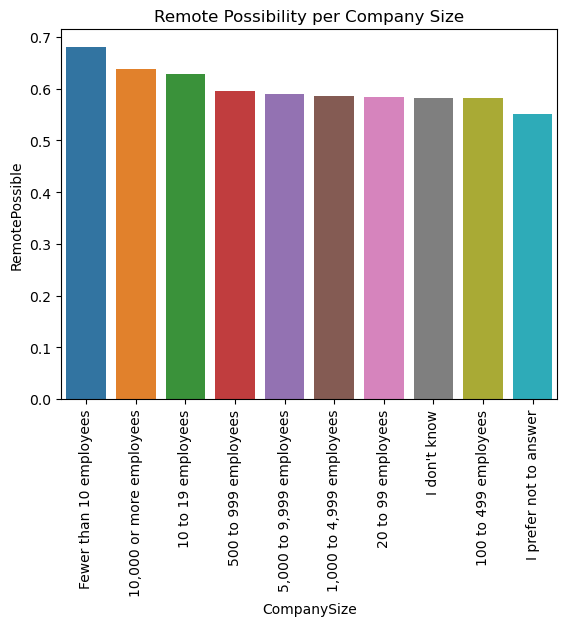

In [31]:
company_size_remote_plot = (
    hr.groupby(["CompanySize"])
    .mean()["RemotePossible"]
    .sort_values(ascending=False)
    .reset_index()
)

cs = sns.barplot(x="CompanySize", y="RemotePossible", data=company_size_remote_plot)
plt.title("Remote Possibility per Company Size")
cs.set_xticklabels(cs.get_xticklabels(), rotation=90)

The answer is no, there is no linear trends in smaller companies having a higher probability to work from home. The smallest companies have the highest percentile of remote workers (68%). However they are directly followed by the biggest companies. Second rank with 64% are companies with more than 10,000 employees.

In [29]:
# correlation table for numeric variables and our outcome variable
# df_corr = df[["JobSatisfaction", "Salary", "HoursPerWeek"]]
corr = hr[
    [
        "JobSatisfaction",
        "CareerSatisfaction",
        "Salary",
        "HoursPerWeek",
        "RemotePossible",
        "StackOverflowSatisfaction",
    ]
].corr()
corr.style.background_gradient(cmap="coolwarm")


,JobSatisfaction,CareerSatisfaction,Salary,HoursPerWeek,RemotePossible,StackOverflowSatisfaction
JobSatisfaction,1.000000,0.645897,0.120842,-0.081679,0.102625,0.088187
CareerSatisfaction,0.645897,1.000000,0.158139,-0.040252,0.106026,0.152210
Salary,0.120842,0.158139,1.000000,-0.120332,0.163761,-0.076669
HoursPerWeek,-0.081679,-0.040252,-0.120332,1.000000,0.036231,-0.003217
RemotePossible,0.102625,0.106026,0.163761,0.036231,1.000000,-0.004251
StackOverflowSatisfaction,0.088187,0.152210,-0.076669,-0.003217,-0.004251,1.000000


The correlation graph reveals the Career and Job Satisfaction to be highly positively correlated. 
When looking at RemotePossible, the highest correlations appear for Salary. This might also be important for the prediction question I want to answer below.

### Model data

### Question 5:  What are the determining factors in predicting if working from home is possible?
For the prediction question, I first need to clean the data, that we take into account for the prediction. It is very important to think about missing values and how to handle them. For prediction I have to create dummies for categorical variables.The numeric columns will be filled with the mean, as I do not want to lose to much data with it and already filtered out people with no employment. 

In [30]:
#write function to clean data for prediction
def clean_data(hr: pd.DataFrame, cat_vars: list):
    """
    The function cleans and preprocesses the prepared developer survey data by dropping irrelevant columns, filling missing values
    with mean, and creating dummy variables for categorical variables.
    
    :param hr: A pandas DataFrame with developer survey data 
    :type hr: pd.DataFrame
    :param cat_vars: A list of categorical variables in the hr DataFrame that need to be converted into
    dummy variables
    :type cat_vars: list
    :return: two variables, X and y. X is a cleaned version of the input DataFrame hr, with numeric
    columns filled with the mean and categorical variables converted to dummy variables. y is a Series
    containing the values of the "RemotePossible" column from the original hr DataFrame.
    """
    df = hr.copy()

    # Define possibility to work from home as y
    y = df["RemotePossible"]

    # Drop respondent id, and Remote variable
    df = df.drop(["Respondent", "RemotePossible"], axis=1)

    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=["float", "int"]).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
    cols_to_keep = list(num_vars) + cat_vars
    df = df[cols_to_keep]

    # Dummy the categorical variables
    # cat_vars = df.select_dtypes(include=["object"]).copy().columns
    for var in cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat(
            [
                df.drop(var, axis=1),
                pd.get_dummies(df[var], prefix=var, prefix_sep="_", drop_first=True),
            ],
            axis=1,
        )

    X = df
    return X, y


In [31]:
# clean data with the above function
X, y = clean_data(
    hr,
    [
        "Professional",
        "ProgramHobby",
        "country_groups",
        "EmploymentStatus",
        "FormalEducation",
        "CompanySize",
    ],
)


In [32]:
# take a look at the data 
X.head()


,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary,Professional_Professional developer,Professional_Professional non-developer who sometimes writes code,Professional_Student,Professional_Used to be a professional developer,...,FormalEducation_Some college/university study without earning a bachelor's degree,CompanySize_10 to 19 employees,"CompanySize_10,000 or more employees",CompanySize_100 to 499 employees,CompanySize_20 to 99 employees,"CompanySize_5,000 to 9,999 employees",CompanySize_500 to 999 employees,CompanySize_Fewer than 10 employees,CompanySize_I don't know,CompanySize_I prefer not to answer
1,7.368747,6.957222,3.566124,8.000000,56296.698228,37500.000000,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
2,8.000000,9.000000,3.566124,8.000000,113750.000000,35537.950277,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,6.000000,3.000000,5.000000,10.000000,56296.698228,35537.950277,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,6.000000,8.000000,3.566124,8.453235,56296.698228,35537.950277,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6,7.000000,6.000000,1.000000,8.000000,56296.698228,35537.950277,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [33]:
y.head()

1    1
2    1
3    1
4    0
6    1
Name: RemotePossible, dtype: int64

For prediction, I first split the data into train and test set

In [34]:
# Split data into training and test data, and fit a logistic regression model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)


Then I run a random forest model on the training data set

In [35]:
clf = RandomForestClassifier(
    n_estimators=80, max_samples=500, max_features=0.5, min_samples_leaf=5
)
clf.fit(X_train.values, y_train.values)


RandomForestClassifier(max_features=0.5, max_samples=500, min_samples_leaf=5,
                       n_estimators=80)

And predict the trained model on the test set

In [36]:
y_pred = clf.predict_proba(X_test.values)
y_pred[:2]


array([[0.61712031, 0.38287969],
       [0.47004426, 0.52995574]])

In [37]:
#train score
print(clf.score(X_train.values, y_train.values, sample_weight=None))
# test score
print(clf.score(X_test.values, y_test.values, sample_weight=None))


0.6675974932623308
0.6586862641109175


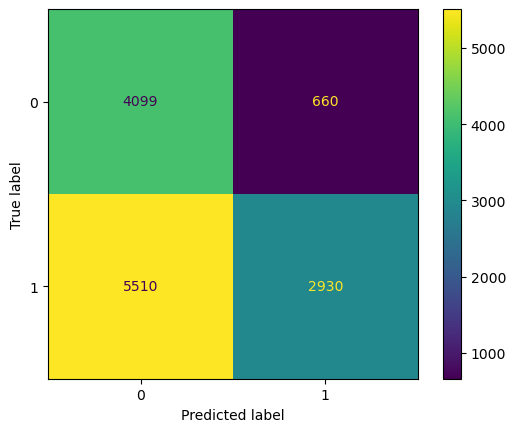

In [38]:
cm = confusion_matrix(y_test, np.where(y_pred[:, 1] < 0.7, 0, 1))

ConfusionMatrixDisplay(confusion_matrix=cm).plot()


Take a look at the accuracy score, based on the threshold it will change 

In [39]:
threshold = [0.3, 0.4, 0.5, 0.6, 0.7]
for i in threshold:
    accuracy = accuracy_score(y_test, np.where(y_pred[:, 1] < i, 0, 1))
    precision = precision_score(y_test, np.where(y_pred[:, 1] < i, 0, 1))
    recall = recall_score(y_test, np.where(y_pred[:, 1] < i, 0, 1))

    print ("Threshold", i)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)


Threshold 0.3
Accuracy: 0.6394423819986362
Precision: 0.6394423819986362
Recall: 1.0
Threshold 0.4
Accuracy: 0.6443669974998106
Precision: 0.643393048537743
Recall: 0.9957345971563981
Threshold 0.5
Accuracy: 0.6586862641109175
Precision: 0.6707158351409979
Recall: 0.9158767772511849
Threshold 0.6
Accuracy: 0.633305553451019
Precision: 0.7338269680436477
Recall: 0.6693127962085308
Threshold 0.7
Accuracy: 0.5325403439654519
Precision: 0.8161559888579387
Recall: 0.3471563981042654


Dependent on the threshold, the outcome will accuracy, precision and recall will change. If I am more interested in predicting no-remote workers correctly, the threshold should be higher, accuracy will be lower and precision higher. 

In [40]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

<AxesSubplot:>

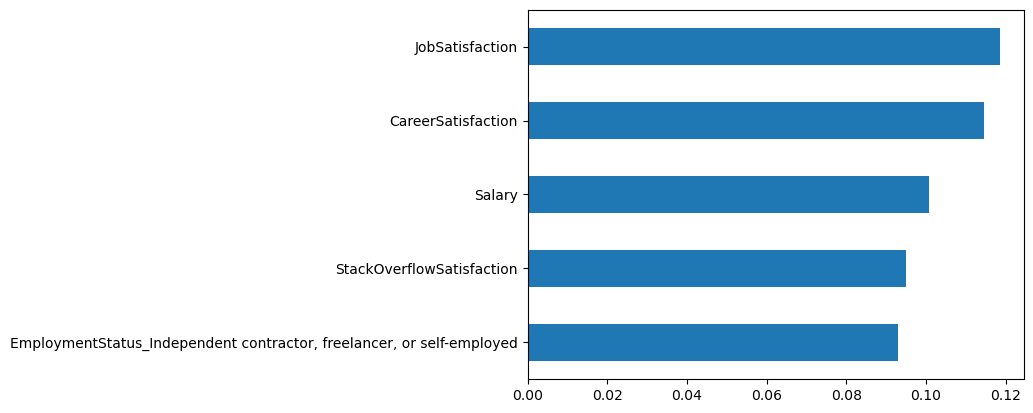

In [41]:
(pd.Series(feature_importances)#, index=X.columns)
   .nlargest(5)
   .sort_values(ascending=True)
   .plot(kind='barh'))       

The most important factors for working from home prediction are Job Satisfaction, Carrer Satisfaction and Salary. This could already be anticipated with the high positive correlation. The predictions 5 most important features also contain the employment status and stackoverflow satisfaction. 